In [73]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [74]:
def lut(c, x):
    if(c == 0):
        if x == 0: 
            return 0 
        if x == 1:
            return 1
        if x == 2:
            return 2
        if x == 3: 
            return 4
        if x == 4:
            return 8
        if x == 5: 
            return 3 
        if x == 6:
            return 6
        if x == 7: 
            return 12 
        if x == 8:
            return 11
        if x == 9:
            return 5
        if x == 10: 
            return 10 
        if x == 11:
            return 7
        if x == 12: 
            return 14 
        if x == 13:
            return 15
        if x == 14: 
            return 13
        if x == 15:
            return 9
    if(c == 1):
        if x == 0: 
            return 0 
        if x == 1:
            return 1
        if x == 2:
            return 2
        if x == 4: 
            return 3
        if x == 8:
            return 4
        if x == 3: 
            return 5
        if x == 6:
            return 6
        if x == 12: 
            return 7 
        if x == 11:
            return 8
        if x == 5:
            return 9
        if x == 10: 
            return 10 
        if x == 7:
            return 11
        if x == 14: 
            return 12
        if x == 15:
            return 13
        if x == 13: 
            return 14
        if x == 9:
            return 15

In [75]:
# symbols, chip recieves binary input
def mult(a,b):
    if a == 0 or b == 0: 
        return 0 
    else: 
        return (a-1 + b-1) % 15 + 1
    
# multiply coefficients of a polynomial by a constant
def mult_poly_coeff(p, a):
    m = []
    for i in range(len(p)): 
        m.append(mult(p[i], a))
    return m
        

In [76]:
# take in symbols, perform xor addition
def add(a, b): 
    a_temp = lut(0, a)
    b_temp = lut(0, b)
    return lut(1, a_temp ^ b_temp)

# add two polynomials
def add_poly(a, b):
    s = []
    for i in range(len(a)):
        s.append(add(a[i],b[i]))
    return s
    

In [77]:
M = [0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] # M*X^n-k
# perform multiplication by a power of X
def shift_left(arr, n):
    n = n % len(arr) 
    if n == 0:
        return arr
    else:
        return arr[n:] + arr[:n]

def compute_remainder(M):
    # G = [1, 11, 15, 5, 7, 10, 7] 
    G = [0, 0, 0, 0, 0, 0, 0, 0, 1, 11, 15, 5, 7, 10, 7] # generator
    T = M
    for i in range(15):
        t = T[i] 
        deg = 14-i
        if(i == 9): 
            return T
        elif(t == 0):
            continue
        else:
            G_new = mult_poly_coeff(G, t)
            temp = shift_left(G_new, deg-6)
            T = add_poly(T, temp)
            
        
    return -1
               
def compute_encoding(M):
    CK = compute_remainder(M)
    return M[0:9] + CK[9:]
                

C = compute_encoding(M)
    
    
    
print(C)
    

[0, 0, 10, 0, 0, 0, 0, 0, 0, 2, 2, 8, 14, 4, 5]


In [78]:
# generate source that sends symbols, returns message in terms of symbols
def generate_test_vectors(n):
    v = []
    sym = []
    for i in range(n): 
        v_ = list(np.random.randint(0, 15, 9))
        for i in range(6): 
            v_.append(0)
        v.append(v_)
        
    # write test vectors to source file
    FILE = open("source.act", "w")
    FILE.write("defproc source_tst(chan(int<4>)!X) { \n")
    FILE.write("  chp { \n")
    for j, m in enumerate(v):
        for i in range(9):
            if j == n - 1 and i == 8:
                FILE.write("    X!{0}; log(\"Sent \", {0}) \n".format(m[i]))
            else:
                FILE.write("    X!{0}; log(\"Sent \", {0}); \n".format(m[i]))
    FILE.write("  }\n")
    FILE.write("}\n")
    
    #subprocess.call("actsim test_RS.act test < cmd.src > test.txt", shell=True)
    
    
    return v

p = generate_test_vectors(10)

In [79]:
def check_output(outfile, message): 
    exp = []
    for m in message: 
        C = compute_encoding(m)
        for c in C:
            exp.append(c)
        
        
    FILE = open(outfile, "r")
    received = []
    sent = []
    for line in FILE: 
        line_token = line.split(" ")
        if "Received" in line_token: 
            received.append(int(line_token[-1]))
        if "Sent" in line_token: 
            sent.append(int(line_token[-1]))
        
    #plt.plot(received[15:])
    plt.plot(exp,received[15:])
    e = np.sum(np.array(exp) - np.array(received[15:]))
    return e

0

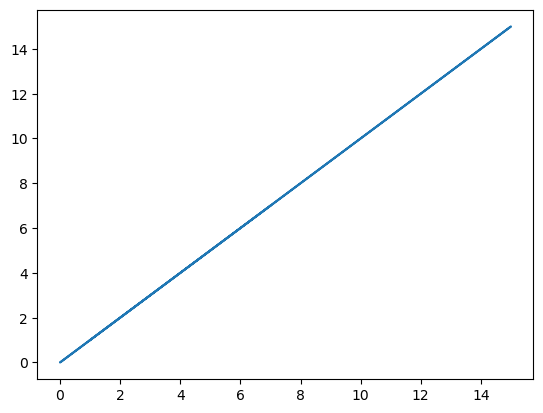

In [80]:
e = check_output("test.txt", p)
e